Thermochemical convection
======

This notebook models the entrainment of a thin dense layer by thermochemical convection as outlined in van Keken *et al.* (1997). 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = (Ra T - Rb \Gamma )\mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

where $Ra$ and $Rb$ are the thermal and compositional Rayleigh numbers defined as 

$$
    Ra = \frac{\alpha\rho g \Delta T h^3}{\kappa \eta_{ref}}   ;   Rb = \frac{ \Delta\rho g h^3}{\kappa\eta_{ref}}
$$

where $\alpha$ is thermal expansivity, $\rho$ density, $g$ gravity, $\Delta t$ temperature difference between the top and bottom, $h$ depth of layer, $\kappa$ thermal diffusivity, $\eta_{ref}$ the reference viscosity and $\Delta\rho$ the density difference between the top and bottom layer.

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np
import matplotlib.pyplot as pyplot
uw.matplotlib_inline()

In [2]:
Ra = 3.0e5
Rb = 4.5e5

width  = 2.
height = 1.
aspect = width / height

unitRes = 32

In [3]:
inputPath  = './input/1_18_ThermochemicalConvection/'
outputPath = './output/'
# Make output directory if necessary.
if uw.rank()==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

Create mesh and finite element variables
------

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (int(unitRes*aspect), unitRes), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (width, height))

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# initialise 
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureField.data[:]    = 0.
temperatureDotField.data[:] = 0.

Create a particle swarm
------

In [5]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

Initialise each particle's material index
-----

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# Create function to return particle's coordinate
coord = fn.coord()

# Setup the conditions list. 
# If z is greater than 0.025, set to light material
conditions = [ ( coord[1] > 0.025 , lightIndex ),
               (             True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Plot the particles by material**


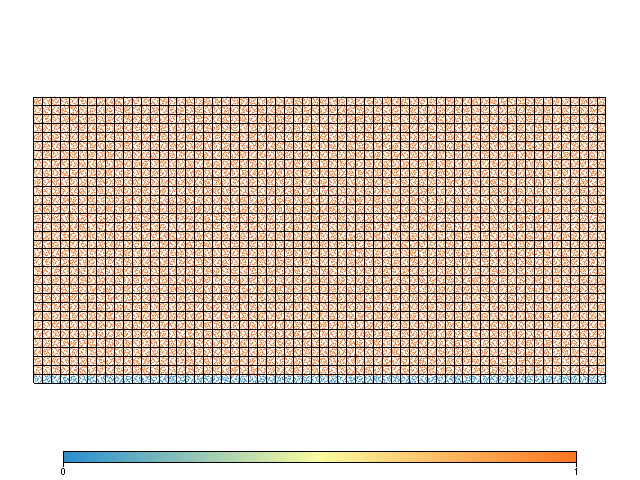

In [7]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Points(swarm, materialIndex, pointSize=2) )
fig1.append( glucifer.objects.Mesh(mesh))
fig1.show()

Apply material properties
-----

In [8]:
# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = { lightIndex:0., denseIndex:1. }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

Initialise temperature field
------

In [9]:
# Appendix A: Initial temperature field
pi = math.pi
x  = fn.coord()[0]
y  = fn.coord()[1]

Lambda = aspect  # aspect ratio = 2.
u0 = math.pow( Lambda , 7.0/3.0 )/ math.pow((1 + Lambda**4.), 2.0/3.0) * math.pow((0.5*Ra/math.sqrt(pi)) , 2.0/3.0)
v0 = u0
Q = 2.0 * fn.math.sqrt(Lambda/(pi*u0))


Tu = 0.5 * fn.math.erf( 0.5 * ( 1. - y ) * fn.math.sqrt(u0/x) )
Tl = 1.0 - 0.5 * fn.math.erf(0.5 * y * fn.math.sqrt(u0/(Lambda-x)))
Tr = 0.5 + 0.5*Q/fn.math.sqrt(pi) * fn.math.sqrt(v0/(y+1.)) * fn.math.exp( -x*x*v0/(4.*y+4.) )
Ts = 0.5 - 0.5*Q/fn.math.sqrt(pi) * fn.math.sqrt(v0/(2.-y)) * fn.math.exp(-(Lambda-x)*(Lambda-x)*v0/(8.-4.*y))

temperatureFn = fn.misc.min( fn.misc.max(Tu + Tl + Tr + Ts - 1.5, fn.misc.constant(0.)), fn.misc.constant(1.0))

In [10]:
temperatureField.data[:] = temperatureFn.evaluate(mesh)

In [11]:
# Apply max and min temperature to top and bottom
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.0
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.


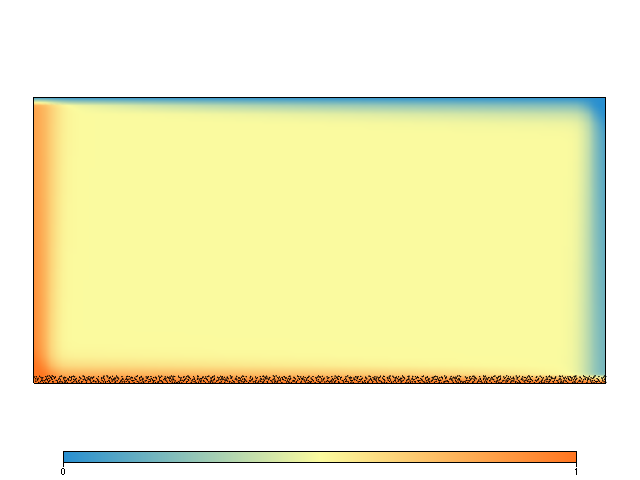

In [12]:
materialFilter = materialIndex < 1
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, temperatureField) )
fig.append( glucifer.objects.Points(swarm, fn_mask=materialFilter, pointSize=2))
fig.show()

Boundary conditions
-----

Create free-slip condition on the vertical boundaries, and a no-slip condition on the horizontal boundaries.

In [13]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

# Prescribe free-slip boundary conditions on all walls
freesipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                            indexSetsPerDof = (iWalls, jWalls) )
tempBC    = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                            indexSetsPerDof = (jWalls,) )

Define the buoyuancy force term and viscosity function
=====

In [14]:
# Define z_hat in the direction of gravity
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = ( Ra * temperatureField - Rb * densityFn) * z_hat

# define viscosity function as constant
viscosityFn = fn.misc.constant(1.0)

Create systems
-----

In [15]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            voronoi_swarm = swarm, 
                            conditions    = freesipBC,
                            fn_viscosity  = viscosityFn, 
                            fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

# Create advection diffusion system
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

Time stepping
-----

In [16]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = min(advector.get_max_dt(), advDiff.get_max_dt())
    # Advect and diffuse
    advector.integrate(dt)
    advDiff.integrate(dt)
    return time+dt, step+1

In [17]:
# functions for calculating RMS velocity
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(outputPath+"Mesh.h5")

In [18]:
# Initialise time and timestep.
time = 0.
step = 0

timeVal = []
vrmsVal = []

In [19]:
# set timeEnd = 0.05 for full benchmark
timeEnd      = 0.0005 
outputEvery  = 10

step =      0; time = 0.000e+00; v_rms = 3.835e+02
step =     10; time = 1.597e-04; v_rms = 3.750e+02
step =     20; time = 3.282e-04; v_rms = 3.477e+02
step =     30; time = 5.153e-04; v_rms = 3.160e+02



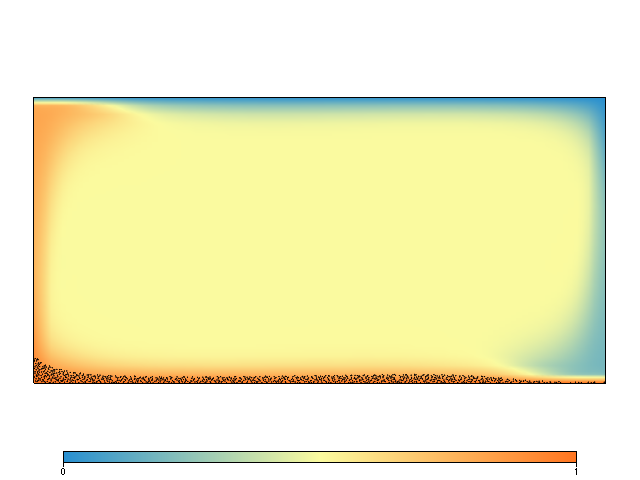

In [20]:
while time < timeEnd:
    # Get instantaneous Stokes solution
    solver.solve()
    # Calculate the RMS velocity.
    vrms = math.sqrt( v2sum_integral.evaluate()[0] / volume_integral.evaluate()[0] )

    # Record values into arrays
    if(uw.rank()==0):
        vrmsVal.append(vrms)
        timeVal.append(time)
    
    # Output to disk
    if(uw.rank()==0):
        with open(outputPath+'/FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, vrms)), fmt='%.8e')
    
    if step%outputEvery == 0:
        if(uw.rank()==0):
            print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))
            
        fig.save_image(outputPath+"thermochem."+str(step).zfill(4))
    
    # We are finished with current timestep, update.
    time, step = update()
    
if(uw.rank()==0):
    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))
    fig.show()

Post simulation analysis
-----

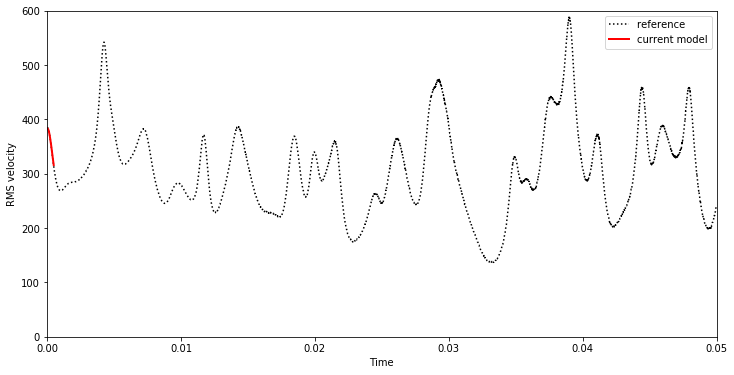

In [21]:
if uw.nProcs() == 1:
    fig = pyplot.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    # load saved data
    data = np.loadtxt(inputPath+'Thermochem-vrms-res128x64.dat', unpack=True )
    step1, time1, vrms1 = data[0], data[1], data[2]
    ax.plot(time1, vrms1,  label='reference ', linestyle=":", color='k')
    # plot current models vrms with time
    ax.plot(timeVal, vrmsVal, label='current model', linewidth=2, color = 'red') 
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS velocity')
    ax.set_xlim([0.0,0.05])
    ax.set_ylim([0.0,600.])
    ax.legend()
